In [17]:
import pennylane as qml
import numpy as np
import torch
from torch import optim
from pennylane_ionq import SimulatorDevice
API_KEY = "1M2CfwlG0uQPCJCNulP2rGYd9JTlXLbS"

In [18]:
# functeion which conputes set of board, empty_rows, nonempty_rows
def status(horses,size):
    total_horses = horses 
    board = np.zeros((size,size))   
    row_list = [i for i in range(size)]

    nonempty_rows = [h[0] for h in total_horses]
    empty_rows = [x for x in row_list if x not in nonempty_rows]
    nonempty_rows.sort()

    for h in total_horses:
        board[h[0]][h[1]] = 1

    return board, empty_rows

In [19]:
# draw board
def draw(board):
    boxes = ['□', '◆']
    for row_board in board.tolist():
      for b in row_board:
        print(boxes[int(b)], end ='')
      print()

In [20]:
size = 4
num_qubits = size ** 2


def state_vec(weights, board,empty_rows):
    
    board = board.astype(int).reshape(1,-1).reshape([size**2,])
    qml.BasisStatePreparation(board, wires= range(num_qubits) )    

    for w in weights:
        th_count = 0
        n = size    
        for e in empty_rows:
            pivot = n * e 
            for j in range(n):
                qml.RX(w[th_count], wires = [pivot + j])
                th_count += 1
                qml.RY(w[th_count], wires = [pivot + j])
                th_count += 1

    return qml.probs()

# convert (size**2,1) tensor -> nomalized (size,size) tensor
def nomalization(result):
    return (-torch.FloatTensor(result).reshape([size,size])+1)*.5

In [21]:
def circuit(weights, board, empty_rows):


    board = board.astype(int).reshape(1,-1).reshape([size**2,])
    qml.BasisStatePreparation(board, wires= range(num_qubits) )    

    for w in weights:
        th_count = 0
        n = size    
        for e in empty_rows:
            pivot = n * e 
            for j in range(n):
                qml.RX(w[th_count], wires = [pivot + j])
                th_count += 1
                qml.RY(w[th_count], wires = [pivot + j])
                th_count += 1



    result = [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]
    return result

## Cost function (for 4X4 Board)

In [22]:
def cost_fn(result, empty_rows):
    
    ham = 0

    b = torch.stack(result, dim=0)
    result = b.reshape(size,size)
    
    # ham += torch.sum(b)

    for i in empty_rows:
        ham += (torch.sum(result[i])-size+2)*(torch.sum(result[i])-size+2)
    for i in range(size):
        ham += (torch.sum(result.T[i])-size+2)*(torch.sum(result.T[i])-size+2)


    for i in range(2*size-3): # 대각선 개수 2*size -1 -2(대각선 요소 1개인 것)
        diag1 = torch.diagonal(result,i-2)
        diag2 = torch.diagonal(torch.flip(result,[-1]),i-2)
        ham += torch.abs((torch.sum(diag1)-len(diag1))*(torch.sum(diag1)-len(diag1)+2))
        ham += torch.abs((torch.sum(diag2)-len(diag2))*(torch.sum(diag2)-len(diag2)+2))
    return ham


## Optimization

In [39]:
# define pennylane device 
dev = qml.device("default.qubit.torch", wires=num_qubits)

circuit_qnode = qml.QNode(circuit, device=dev,interface= 'torch' , diff_method='backprop')
state_vec_qnode = qml.QNode(state_vec, device=dev,interface= 'torch')


# set parameter
horses = [[0,2]]
board, empty_rows = status(horses,size)

num_layers = 1
N_iter = 100

weights = torch.tensor(torch.rand(num_layers , 2*size*len(empty_rows)), requires_grad = True)


C:\Users\wlsgu\AppData\Local\Temp\ipykernel_6020\3071470088.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(torch.rand(num_layers , 2*size*len(empty_rows)), requires_grad = True)


In [40]:
# Output the status of weights, cost, and board before implementation
exp_val = circuit_qnode(weights,board,empty_rows)
exp_board = nomalization(exp_val)
cost = cost_fn(exp_val, empty_rows)
print('cost is : ', float(cost))
print('board is ', np.array(exp_board))
print('weight is ',weights)

cost is :  15.947429127238376
board is  [[0.         0.         1.         0.        ]
 [0.00281569 0.12143067 0.18953195 0.00508183]
 [0.12059122 0.14045438 0.12419283 0.21999398]
 [0.20664483 0.15909028 0.08693597 0.12881511]]
weight is  tensor([[0.0898, 0.0567, 0.2613, 0.6701, 0.1049, 0.8965, 0.0134, 0.1421, 0.0227,
         0.7090, 0.6935, 0.3624, 0.0027, 0.7203, 0.7602, 0.6877, 0.6628, 0.7313,
         0.0099, 0.8205, 0.5049, 0.3365, 0.6556, 0.3583]], requires_grad=True)


### Draw Circuit

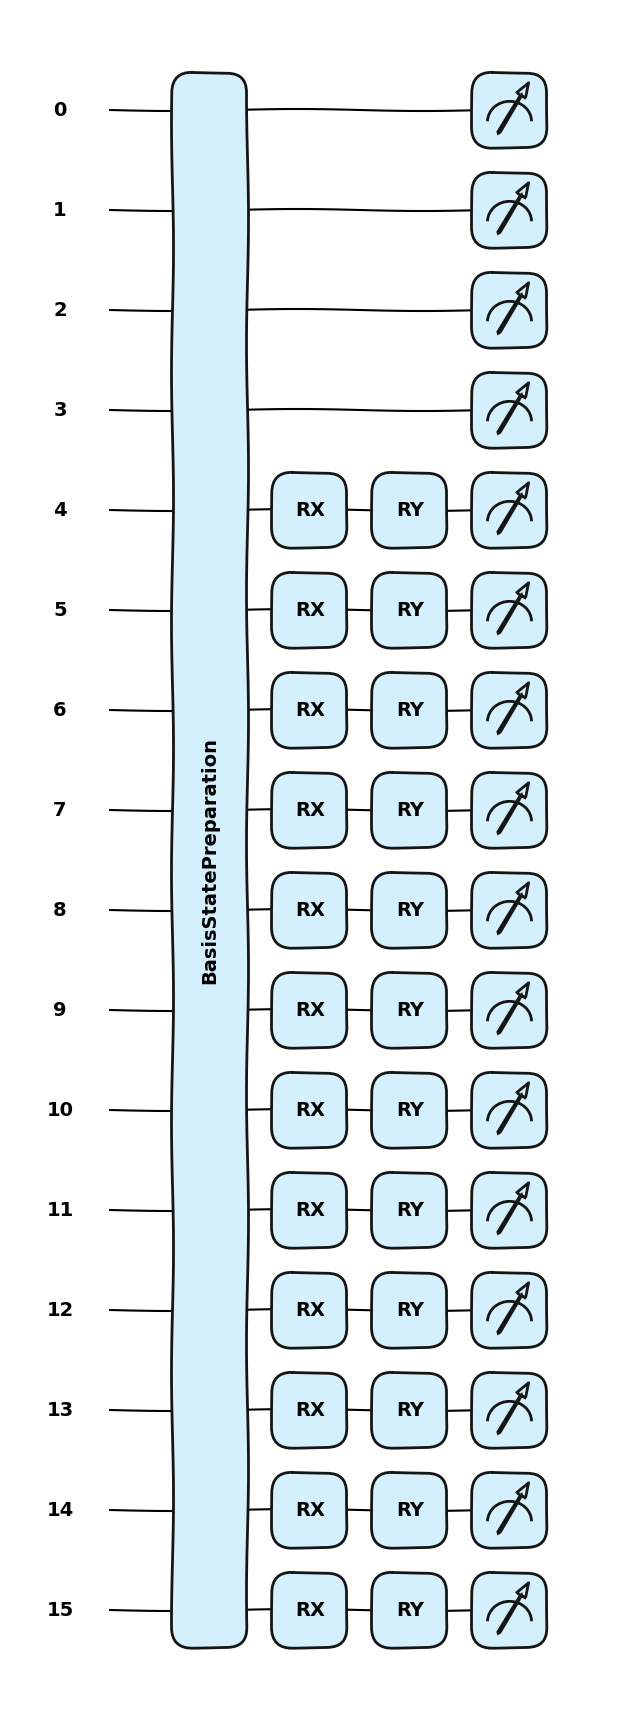

In [25]:
fig, ax = qml.draw_mpl(circuit,style= 'pennylane_sketch')(weights, board, empty_rows)

### Start optimazation

In [41]:
# start optimizing weights
optimizer = optim.Adam([weights],lr=.7)

loss = []
for it in range(N_iter):
    cost = cost_fn(circuit_qnode(weights,board,empty_rows), empty_rows)
    loss.append(float(cost))
    optimizer.zero_grad() 
    cost.backward() 
    optimizer.step() 
    print('iteration number : ', it,' cost is ', cost)

iteration number :  0  cost is  tensor(15.9474, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  1  cost is  tensor(19.1016, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  2  cost is  tensor(12.6115, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  3  cost is  tensor(10.3772, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  4  cost is  tensor(11.3639, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  5  cost is  tensor(13.3183, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  6  cost is  tensor(12.5236, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  7  cost is  tensor(10.7354, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  8  cost is  tensor(10.2090, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  9  cost is  tensor(9.1188, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  10  cost is  tensor(11.0563, dtype=torch.float64, g

## Result

In [42]:
# Output cost and board status after optimization is complete
state_f = state_vec_qnode(weights,board,empty_rows)
exp_val = circuit_qnode(weights,board,empty_rows)
exp_board = nomalization(exp_val)
cost = cost_fn(exp_val, empty_rows)

print('cost is : ', float(cost))
print('board is ', np.array(exp_board))
print('weight is ',weights)

cost is :  0.004287319268223232
board is  [[-1.1920929e-07 -1.1920929e-07  1.0000001e+00 -1.1920929e-07]
 [ 9.9988258e-01  1.2904406e-05  6.4760447e-05  2.8908253e-06]
 [ 8.6009502e-05  1.2993813e-04  5.2392483e-05  9.9984872e-01]
 [ 2.3543835e-06  9.9993569e-01  2.9689074e-04  1.7285347e-05]]
weight is  tensor([[-2.1674e-02, -3.1424e+00, -1.4566e-03, -7.0786e-03,  1.1815e-02,
         -1.0958e-02, -7.7553e-04,  3.3961e-03,  1.4936e-03,  1.8505e-02,
         -1.0873e-02,  2.0055e-02,  1.6226e-03,  1.4407e-02,  3.1576e+00,
         -1.8688e-02,  3.1439e+00,  3.1438e+00,  6.6879e-03,  3.1562e+00,
         -5.5712e-03,  3.4019e-02,  3.1484e+00,  3.1368e+00]],
       requires_grad=True)


In [43]:
result_state = torch.argmax(state_f) # The state with the highest probability 
print(format(result_state,'016b'),'\nprobablity is ', float(max(state_f))*100,'%')
draw(np.array([int(i) for i in format(result_state,'016b')]).reshape([4,4]))

0010100000010100 
probablity is  99.90004318816274 %
□□◆□
◆□□□
□□□◆
□◆□□


### LOSS

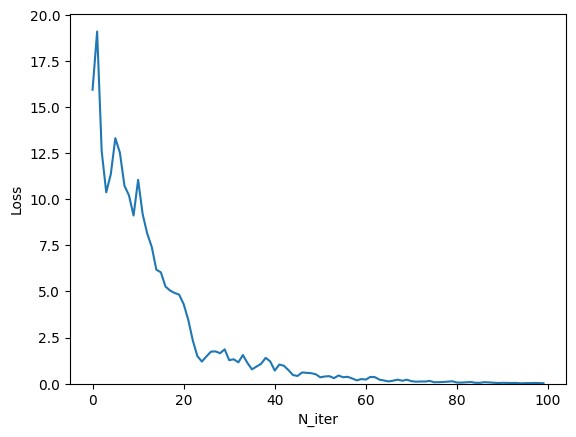

In [44]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('N_iter')
plt.ylabel('Loss')
plt.ylim(0)
plt.savefig('loss')
plt.show()

## Excute result using Ionq Cloud Simulator

In [45]:
# dev = qml.device("default.qubit.torch", wires=num_qubits)
Simulator = SimulatorDevice(wires=num_qubits, api_key = API_KEY)

default_qnode = qml.QNode(circuit, device=Simulator,interface= 'torch')
default_qnode1 = qml.QNode(state_vec, device=Simulator,interface= 'torch')

In [46]:
prob = default_qnode1(weights,board,empty_rows)

In [47]:
a = torch.argmax(state_f) # The state with the highest probability 
print(format(a,'016b'),'\nprobablity is ', float(max(state_f))*100,'%')
draw(np.array([int(i) for i in format(a,'016b')]).reshape([4,4]))

0010100000010100 
probablity is  99.90004318816274 %
□□◆□
◆□□□
□□□◆
□◆□□


## Excute result using Ionq Cloud QPU

In [63]:
from pennylane_ionq import QPUDevice

Real_backend = QPUDevice(wires=num_qubits, backend= "aria-1",  api_key = API_KEY)

Real_backend_qnode = qml.QNode(circuit, device=Real_backend, interface= 'torch')
Real_backend_qnode1 = qml.QNode(state_vec, device=Real_backend, interface= 'torch')

In [64]:
real_probs = Real_backend_qnode1(weights,board,empty_rows)

In [65]:
probs = torch.argmax(real_probs) # The state with the highest probability 
print(format(probs,'016b'),'\nprobablity is ', float(max(real_probs))*100,'%')
draw(np.array([int(i) for i in format(probs,'016b')]).reshape([4,4]))

0010100000010100 
probablity is  91.41463414634147 %
□□◆□
◆□□□
□□□◆
□◆□□
